In [45]:
from time import sleep

import numpy as np
import xarray as xr
from dask.diagnostics import ProgressBar

from simulation_tutorial import xarray_mods as xrmod

## vectorize

In [ ]:
def kinetic_energy_j(m_kg, v_mps):
    return 0.5 * m_kg * v_mps**2

In [72]:
ds = xr.Dataset()
ds["v_mps"] = np.linspace(0, 10)
ds.v_mps.attrs = {"long_name": "Velocity", "units": "m/s"}
ds["m_kg"] = np.linspace(3, 17)
ds.m_kg.attrs = {"long_name": "Mass", "units": "kg"}
ds["Ekin_j"] = xr.apply_ufunc(kinetic_energy_j, ds.m_kg, ds.v_mps)
ds.Ekin_j.attrs = {"long_name": "Energy", "units": "J"}
ds

<xarray.Dataset> Size: 21kB
Dimensions:  (v_mps: 50, m_kg: 50)
Coordinates:
  * v_mps    (v_mps) float64 400B 0.0 0.2041 0.4082 0.6122 ... 9.592 9.796 10.0
  * m_kg     (m_kg) float64 400B 3.0 3.286 3.571 3.857 ... 16.43 16.71 17.0
Data variables:
    Ekin_j   (m_kg, v_mps) float64 20kB 0.0 0.06247 0.2499 ... 782.0 815.7 850.0

In [77]:
def kinetic_energy_j_check(m_kg, v_mps):
    if m_kg < 0: # Not allowed for numpy array
        raise ValueError("Mass should be positive!")
    return 0.5 * m_kg * v_mps**2

In [78]:
ds = xr.Dataset()
ds["v_mps"] = np.linspace(0, 10)
ds.v_mps.attrs = {"long_name": "Velocity", "units": "m/s"}
ds["m_kg"] = np.linspace(3, 17)
ds.m_kg.attrs = {"long_name": "Mass", "units": "kg"}
ds["Ekin_j"] = xr.apply_ufunc(kinetic_energy_j_check, ds.m_kg, ds.v_mps)
ds.Ekin_j.attrs = {"long_name": "Energy", "units": "J"}
ds

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [79]:
ds = xr.Dataset()
ds["v_mps"] = np.linspace(0, 10)
ds.v_mps.attrs = {"long_name": "Velocity", "units": "m/s"}
ds["m_kg"] = np.linspace(3, 17)
ds.m_kg.attrs = {"long_name": "Mass", "units": "kg"}
ds["Ekin_j"] = xr.apply_ufunc(kinetic_energy_j_check, ds.m_kg, ds.v_mps, vectorize=True)
ds.Ekin_j.attrs = {"long_name": "Energy", "units": "J"}
ds

<xarray.Dataset> Size: 21kB
Dimensions:  (v_mps: 50, m_kg: 50)
Coordinates:
  * v_mps    (v_mps) float64 400B 0.0 0.2041 0.4082 0.6122 ... 9.592 9.796 10.0
  * m_kg     (m_kg) float64 400B 3.0 3.286 3.571 3.857 ... 16.43 16.71 17.0
Data variables:
    Ekin_j   (m_kg, v_mps) float64 20kB 0.0 0.06247 0.2499 ... 782.0 815.7 850.0

This works but what we should have done:

In [85]:
def kinetic_energy_j_check_fast(m_kg, v_mps):
    if np.all(m_kg < 0): # Allowed for numpy array
        raise ValueError("Mass should be positive!")
    return 0.5 * m_kg * v_mps**2

Use vectorize only if you cannot achieve the same thing with a native numpy function. This will be so much faster.

## output_core_dims 1

In [46]:
sigma = 1
random = np.random.normal(0, sigma, 10)
random

array([-0.63604318, -0.19667355,  0.21475024, -1.18403916,  0.19037466,
       -0.47713259,  0.31730878, -1.57509009, -0.34751674,  1.17911412])

In [47]:
ds = xr.Dataset()
ds['sigma'] = 1
ds['random'] = np.random.normal(0, ds.sigma, 10)
ds

<xarray.Dataset> Size: 88B
Dimensions:  (random: 10)
Coordinates:
  * random   (random) float64 80B 1.624 -0.3101 -0.8885 ... 2.563 1.141 0.7013
Data variables:
    sigma    int64 8B 1

In [48]:
ds = xr.Dataset()
ds['sigma'] =  np.linspace(1,2)
ds['random'] = np.random.normal(0, ds.sigma, 10)
ds

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (10,) and arg 2 with shape (50,).

In [49]:
ds = xr.Dataset()
ds['sigma'] =  np.linspace(1,2)
ds['random'] = xr.apply_ufunc(np.random.normal, 0, ds.sigma, 10, output_core_dims=[['random']], vectorize=True)
ds

<xarray.Dataset> Size: 4kB
Dimensions:  (sigma: 50, random: 10)
Coordinates:
  * sigma    (sigma) float64 400B 1.0 1.02 1.041 1.061 ... 1.939 1.959 1.98 2.0
    random   (sigma, random) float64 4kB -0.1897 0.4044 1.001 ... -1.497 0.9984
Data variables:
    *empty*

## output_core_dims 2

In [93]:
def kinetic_energy_and_momentum(m_kg, v_m_per_s):
    energy = 0.5 * m_kg * v_m_per_s**2
    momentum = m_kg * v_m_per_s
    return energy, momentum

In [94]:
ds = xr.Dataset()
ds["m"] = 5
ds["v"] = np.linspace(0, 10)
ds["Ekin"], ds["momentum"] = xr.apply_ufunc(
    kinetic_energy_and_momentum, ds.m, ds.v, output_core_dims=[[], []]
)
ds

<xarray.Dataset> Size: 1kB
Dimensions:   (v: 50)
Coordinates:
  * v         (v) float64 400B 0.0 0.2041 0.4082 0.6122 ... 9.592 9.796 10.0
Data variables:
    m         int64 8B 5
    Ekin      (v) float64 400B 0.0 0.1041 0.4165 0.9371 ... 230.0 239.9 250.0
    momentum  (v) float64 400B 0.0 1.02 2.041 3.061 ... 46.94 47.96 48.98 50.0

## input_core_dims

In [50]:
random = np.random.normal(0, 1, 10)
std = np.std(random)
std

np.float64(0.7937336235387861)

In [51]:
ds = xr.Dataset()
ds['sigma'] =  1
ds['random'] = xr.apply_ufunc(np.random.normal, 0, ds.sigma, 10, output_core_dims=[['random']], vectorize=True)
ds['stderr'] = np.std(ds.random)
ds

<xarray.Dataset> Size: 96B
Dimensions:  (random: 10)
Coordinates:
  * random   (random) float64 80B -0.7641 -0.5233 1.844 ... 1.552 -0.482 0.8623
Data variables:
    sigma    int64 8B 1
    stderr   float64 8B 0.9997

In [52]:
ds = xr.Dataset()
ds['sigma'] =  1
ds['random'] = xr.apply_ufunc(np.random.normal, 0, ds.sigma, 10, output_core_dims=[['random']], vectorize=True)
ds['stderr'] = xr.apply_ufunc(np.std, ds.random)
ds

ValueError: applied function returned data with an unexpected number of dimensions. Received 0 dimension(s) but expected 1 dimensions with names ('random',), from:

array(0.654134)

In [53]:
ds = xr.Dataset()
ds['sigma'] =  1
ds['random'] = xr.apply_ufunc(np.random.normal, 0, ds.sigma, 10, output_core_dims=[['random']], vectorize=True)
ds['stderr'] = xr.apply_ufunc(np.std, ds.random, input_core_dims=[['random']])
ds

<xarray.Dataset> Size: 96B
Dimensions:  (random: 10)
Coordinates:
  * random   (random) float64 80B -0.8038 0.006827 1.111 ... 2.0 -0.2341 -0.982
Data variables:
    sigma    int64 8B 1
    stderr   float64 8B 1.054

In [58]:
ds = xr.Dataset()
ds['sigma'] =  np.linspace(1,2)
ds['random'] = xr.apply_ufunc(np.random.normal, 0, ds.sigma, 10, output_core_dims=[['random']], vectorize=True)
ds['stderr'] = xr.apply_ufunc(np.std, ds.random, input_core_dims=[['random']])
ds

ValueError: applied function returned data with an unexpected number of dimensions. Received 0 dimension(s) but expected 1 dimensions with names ('sigma',), from:

array(1.565126)

In [54]:
ds = xr.Dataset()
ds['sigma'] =  np.linspace(1,2)
ds['random'] = xr.apply_ufunc(np.random.normal, 0, ds.sigma, 10, output_core_dims=[['random']], vectorize=True)
ds['stderr'] = xr.apply_ufunc(np.std, ds.random, input_core_dims=[['random']], vectorize=True)
ds

<xarray.Dataset> Size: 5kB
Dimensions:  (sigma: 50, random: 10)
Coordinates:
  * sigma    (sigma) float64 400B 1.0 1.02 1.041 1.061 ... 1.939 1.959 1.98 2.0
    random   (sigma, random) float64 4kB 0.01495 0.7192 0.7909 ... 1.914 0.1465
Data variables:
    stderr   (sigma) float64 400B 0.6887 0.9397 0.9472 ... 2.258 1.869 2.664

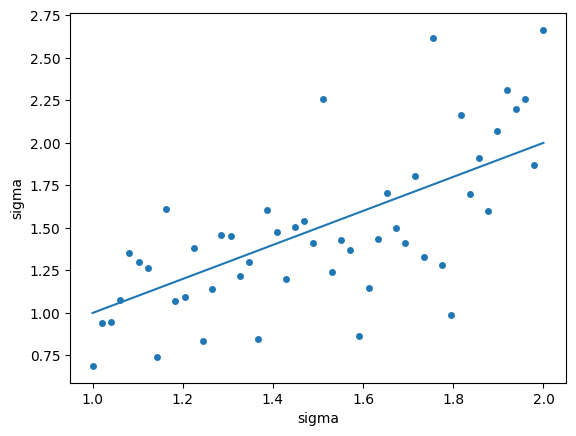

In [57]:
ds.stderr.plot.scatter()
ds.sigma.plot()

Let's start adding labels and units so that the plotting is directly correct.\
'long_name' and 'units' are special attributes of DataArrays.\
Notice that most methods of xarray return a new object rather than modify the old one in place.\
This facilitates chaining of operations in a single line, but pay attention to assign the outcome again.

In [ ]:
ds = xr.Dataset()
ds["m"] = 5
ds.m.attrs = {"long_name": "Mass", "units": "kg"}
ds["v"] = np.linspace(0, 10)
ds.v.attrs = {"long_name": "Velocity", "units": "m/s"}
ds["Ekin"] = xr.apply_ufunc(lib.kinetic_energy_j, ds.m, ds.v)
ds.Ekin.attrs = {"long_name": "Kinetic energy", "units": "J"}
ds

<xarray.Dataset> Size: 808B
Dimensions:  (v: 50)
Coordinates:
  * v        (v) float64 400B 0.0 0.2041 0.4082 0.6122 ... 9.592 9.796 10.0
Data variables:
    m        int64 8B 5
    Ekin     (v) float64 400B 0.0 0.1041 0.4165 0.9371 ... 230.0 239.9 250.0

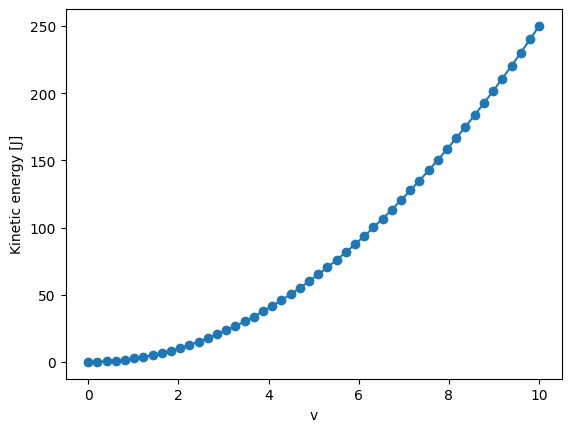

In [8]:
ds.Ekin.plot(marker="o")

Say we would like to vary both a and b independently.

In [ ]:
ds = xr.Dataset()
ds["m"] = np.linspace(3, 17)
ds.m.attrs = {"long_name": "Mass", "units": "kg"}
ds["v"] = np.linspace(0, 10)
ds.v.attrs = {"long_name": "Velocity", "units": "m/s"}
ds["Ekin"] = xr.apply_ufunc(lib.kinetic_energy_j, ds.m, ds.v, keep_attrs=True)
ds.Ekin.attrs = {"long_name": "Kinetic energy", "units": "J"}
ds

<xarray.Dataset> Size: 21kB
Dimensions:  (m: 50, v: 50)
Coordinates:
  * m        (m) float64 400B 3.0 3.286 3.571 3.857 ... 16.14 16.43 16.71 17.0
  * v        (v) float64 400B 0.0 0.2041 0.4082 0.6122 ... 9.592 9.796 10.0
Data variables:
    Ekin     (m, v) float64 20kB 0.0 0.06247 0.2499 0.5623 ... 782.0 815.7 850.0

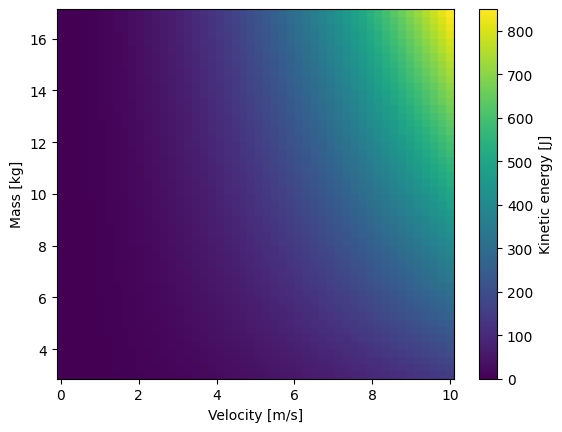

In [12]:
ds.Ekin.plot()

Note that the plotting also got the axis correct by labeling them with the values of a and b.

If you want to vary a and b together you have to give them the same dimension, for example 'index'.

In [ ]:
ds = xr.Dataset()
ds["m"] = xr.DataArray(np.linspace(3, 17), dims="index")
ds.m.attrs = {"long_name": "Mass", "units": "kg"}
ds["v"] = xr.DataArray(np.linspace(0, 10), dims="index")
ds.v.attrs = {"long_name": "Velocity", "units": "m/s"}  
ds["Ekin"] = xr.apply_ufunc(lib.kinetic_energy_j, ds.m, ds.v, keep_attrs=True)
ds.Ekin.attrs = {"long_name": "Kinetic energy", "units": "J"}
ds

<xarray.Dataset> Size: 1kB
Dimensions:  (index: 50)
Dimensions without coordinates: index
Data variables:
    m        (index) float64 400B 3.0 3.286 3.571 3.857 ... 16.43 16.71 17.0
    v        (index) float64 400B 0.0 0.2041 0.4082 0.6122 ... 9.592 9.796 10.0
    Ekin     (index) float64 400B 0.0 0.06842 0.2975 ... 755.7 802.0 850.0

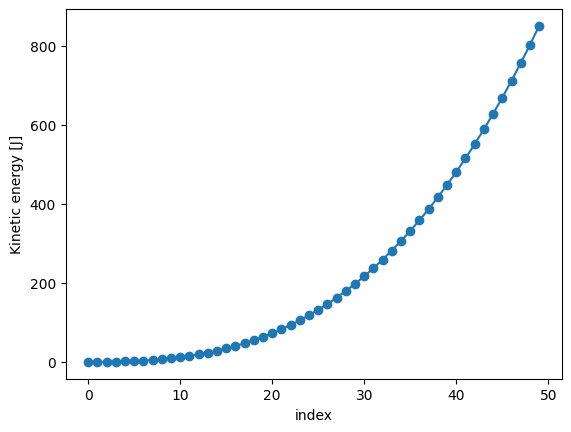

In [14]:
ds.Ekin.plot(marker="o")

# More complex function calls

If your function returns multiple arguments than you can use core_output_dims to define those.
As usually the return values don't have an internal array structure you have to give empty lists.

In [ ]:
def kinetic_energy_and_momentum(m_kg, v_m_per_s):
    energy = 0.5 * m_kg * v_m_per_s**2
    momentum = m_kg * v_m_per_s
    return energy, momentum

In [ ]:
ds = xr.Dataset()
ds["m"] = 5
ds["v"] = np.linspace(0, 10)
ds["Ekin"], ds["momentum"] = xr.apply_ufunc(
    lib.kinetic_energy_and_momentum, ds.m, ds.v, output_core_dims=[[], []]
)
ds

<xarray.Dataset> Size: 1kB
Dimensions:   (v: 50)
Coordinates:
  * v         (v) float64 400B 0.0 0.2041 0.4082 0.6122 ... 9.592 9.796 10.0
Data variables:
    m         int64 8B 5
    E_kin     (v) float64 400B 0.0 0.1041 0.4165 0.9371 ... 230.0 239.9 250.0
    momentum  (v) float64 400B 0.0 1.02 2.041 3.061 ... 46.94 47.96 48.98 50.0

This is also possible with multiprocessing.

If you get errors that input or output dimensions are not as expected have a look at output_core_dims and input_core_dims, these are usually where to properly define what your function expects (input) and what it gets back (output).